# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.io import loadmat
#from tensorflow.keras.callbacks import Callback

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [4]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [15]:
X_train, y_train = train['X'], train['y']
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("\n")
X_test, y_test = test['X'], test['y']
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (32, 32, 3, 73257)
y_train.shape:  (73257, 1)


X_test.shape:  (32, 32, 3, 26032)
y_test.shape:  (26032, 1)


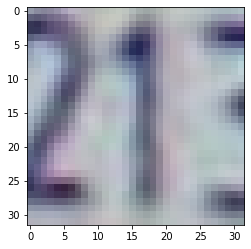

label for example:  6339 

[1]


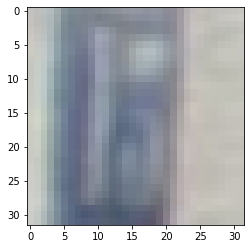

label for example:  72618 

[5]


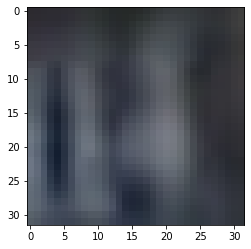

label for example:  9768 

[4]


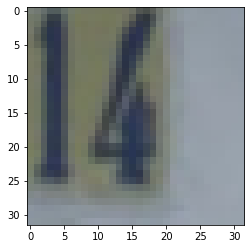

label for example:  45729 

[4]


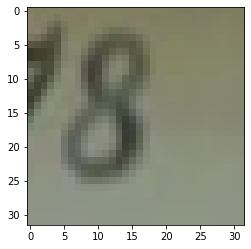

label for example:  4146 

[8]


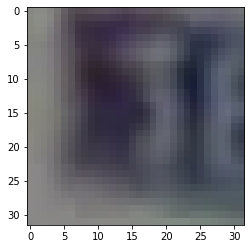

label for example:  42334 

[3]


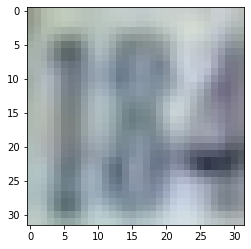

label for example:  56504 

[8]


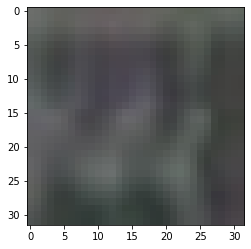

label for example:  47619 

[2]


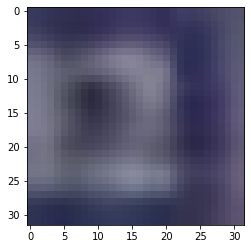

label for example:  56422 

[2]


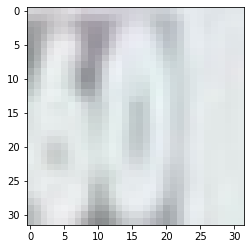

label for example:  19479 

[10]


In [16]:
#samples is an numpy array of 10 elements, each is randomly picked from the range (0, 73257)
samples = np.random.randint(X_train.shape[3], size=10)
for i in samples:
    plt.imshow(X_train[:, :, :, i])
    plt.show()
    print("label for example: ", i, "\n")
    print(y_train[i, :])

In [17]:
#converting each rgb training image into grayscale by taking mean accross the color channels(axis 2)
X_train = np.mean(X_train, axis=2, keepdims=True) #keepdims=True will retain the channel dimension
X_test = np.mean(X_test, axis=2, keepdims=True)

print(X_train.shape)
print(X_test.shape)

(32, 32, 1, 73257)
(32, 32, 1, 26032)


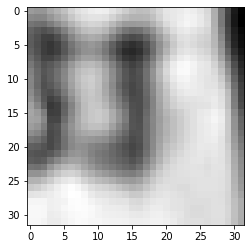

label for example:  11 

[3]


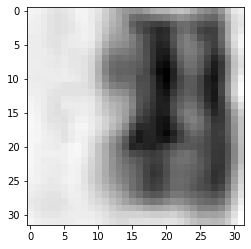

label for example:  22 

[2]


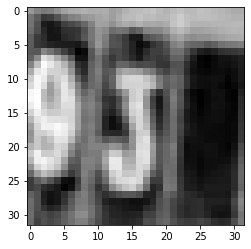

label for example:  7 

[3]


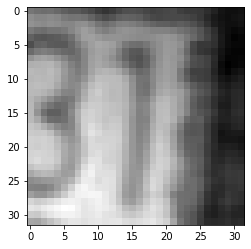

label for example:  9 

[1]


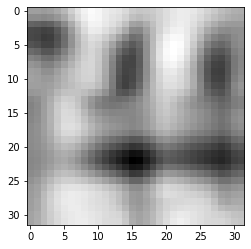

label for example:  15 

[4]


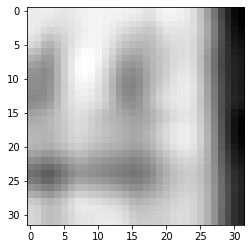

label for example:  16 

[4]


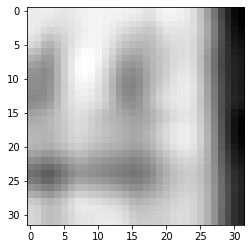

label for example:  16 

[4]


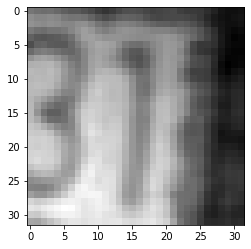

label for example:  9 

[1]


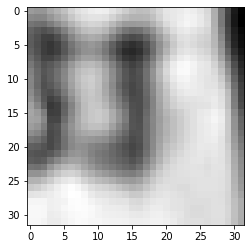

label for example:  11 

[3]


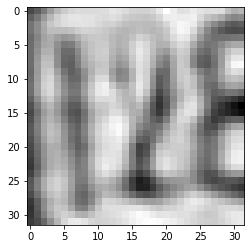

label for example:  18 

[2]


In [19]:
#agin randomly select and display 10 images
samples = np.random.randint(X_train.shape[0], size=10)
for i in samples:
    plt.imshow(X_train[:, :, :, i], cmap='gray')
    plt.show()
    print("label for example: ", i, "\n")
    print(y_train[i, :])

In [21]:
#scale the images
X_train = X_train / 255.
X_test = X_test / 255.

#transpose them for training
X_train = X_train.T
X_test = X_test.T
print("\n")
print(X_train.shape)
print(X_test.shape)



(32, 32, 1, 73257)
(32, 32, 1, 26032)


In [22]:
#in the dataset 0 is labeled with 10 but in the output layer will have 10 units and will output labels 0,...,9
#below, the labels with value 10 are converted to label 0
y_train[ y_train==10 ] = 0

y_test[ y_test==10 ] = 0

In [23]:
#transpose the train and test data so the channel dimension moves to the last axis
#this will be used for training the CNN model since CNN when trained on CPU requires NHWC data format
X_train1 = np.transpose(X_train, (0, 2, 3, 1))
X_test1 = np.transpose(X_test, (0, 2, 3, 1))

print(X_train1.shape)
print(X_test1.shape)

(32, 1, 73257, 32)
(32, 1, 26032, 32)


## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [75]:
#build the model
def get_model_MLP():
    model_MLP = tf.keras.models.Sequential(layers=[
        tf.keras.layers.Flatten(input_shape=(1, 32, 32), data_format='channels_first'),
        tf.keras.layers.Dense(116, activation='relu'),
        tf.keras.layers.Dense(116, activation='relu'),
        tf.keras.layers.Dense(116, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model_MLP

model_MLP = get_model_MLP()

In [76]:
model_MLP.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_34 (Dense)             (None, 116)               118900    
_________________________________________________________________
dense_35 (Dense)             (None, 116)               13572     
_________________________________________________________________
dense_36 (Dense)             (None, 116)               13572     
_________________________________________________________________
dense_37 (Dense)             (None, 10)                1170      
Total params: 147,214
Trainable params: 147,214
Non-trainable params: 0
_________________________________________________________________


In [77]:
#compile the model
model_MLP.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                 loss='sparse_categorical_crossentropy',
                 metrics=['acc'])

In [78]:
#create best checkpoint object for the ModelCheckpoint callback
checkpoint_path = 'checkpoints_best_only_MLP/checkpoint'
checkpoint_best_only = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                 monitor='val_acc',
                                save_weights_only=True,
                                save_best_only=True,
                                save_freq='epoch')

In [79]:
#create checkpoint object for the ModelCheckpoint callback
checkpoint_path = 'checkpoints_every_epoch_MLP/checkpoint_{epoch:02d}'
checkpoint_every_epoch = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_freq='epoch')

In [80]:
#fit the model and store the history object in the history variable
history = model_MLP.fit(X_train, y_train, epochs=30, 
                        batch_size=1000, 
                        validation_split=0.10, 
                        callbacks=[checkpoint_best_only, checkpoint_every_epoch],
                        verbose=False)

In [81]:
#display the train and val metrics during the last five epochs
df = pd.DataFrame(history.history)
df.tail()

,loss,acc,val_loss,val_acc
25,0.714763,0.777358,0.720600,0.777368
26,0.692473,0.785276,0.732732,0.773546
27,0.701155,0.782985,0.713350,0.778324
28,0.686037,0.786762,0.715952,0.777641
29,0.681699,0.789067,0.709265,0.778597


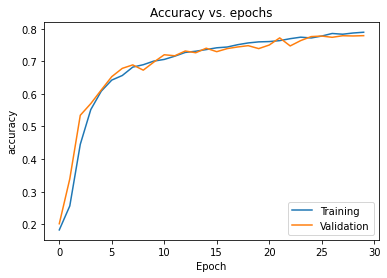

In [82]:
#accuracy vs. epochs
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

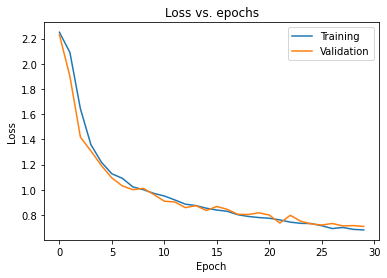

In [83]:
#loss vs. epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [84]:
#evaluate the model's performance on the test data
model_MLP.evaluate(X_test, y_test, verbose=2)

26032/26032 - 1s - loss: 0.8319 - acc: 0.7534


[0.8319379250806903, 0.7533805]

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [87]:
#build the model
def get_model_CNN():
    model_CNN = tf.keras.models.Sequential(layers=[
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(4, 4)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(36, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(18, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model_CNN

model_CNN = get_model_CNN()

In [88]:
model_CNN.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 16)          2320      
_________________________________________________________________
batch_normalization_19 (Batc (None, 8, 8, 16)        

In [89]:
#compile the model
model_CNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                 loss='sparse_categorical_crossentropy',
                 metrics=['acc'])

In [90]:
#create checkpoint object for the ModelCheckpoint ocallback
checkpoint_path = 'checkpoints_every_epoch_CNN/checkpoint_{epoch:02d}'
checkpoint_every_epoch = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                save_weights_only=True,
                                save_freq='epoch')

In [91]:
#create best checkpoint object for the ModelCheckpoint callback
checkpoint_path = 'checkpoints_best_only_CNN/checkpoint'
checkpoint_best_only = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                 monitor='val_acc',
                                save_weights_only=True,
                                save_best_only=True,
                                save_freq='epoch')

In [92]:
#train the model on training data
history = model_CNN.fit(X_train1, y_train, epochs=30,
                        batch_size=1000, 
                        validation_split=0.10, 
                        callbacks=[checkpoint_best_only, checkpoint_every_epoch],
                        verbose=False)

In [93]:
#display the train and val metrics during the last five epochs
df = pd.DataFrame(history.history)

#find the epoch at which the val_acc metric was maximum
best_weight_epoch_CNN = df['val_acc'].idxmax()
print("best_weight_epoch_CNN: ", best_weight_epoch, "\n")
df.tail()

best_weight_epoch_CNN:  27 



,loss,acc,val_loss,val_acc
25,0.382139,0.884061,0.495787,0.846983
26,0.374288,0.885850,0.426847,0.869369
27,0.373031,0.886336,0.434128,0.871963
28,0.374598,0.885365,0.389539,0.885340
29,0.368776,0.888141,0.389441,0.881381


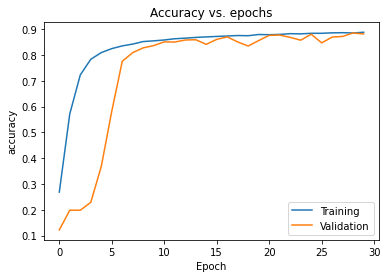

In [94]:
#accuracy vs. epochs
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

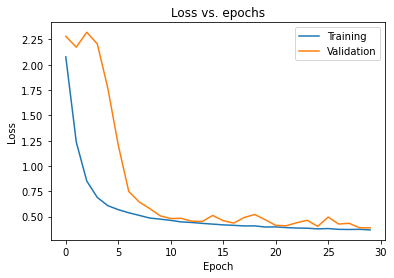

In [95]:
#loss vs. epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [96]:
#evaluate the model's performance on the test data
model_CNN.evaluate(X_test1, y_test, verbose=2)

26032/26032 - 5s - loss: 0.4152 - acc: 0.8777


[0.41519594871162563, 0.87765056]

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [136]:
#get new MLP model
new_model_MLP = get_model_MLP()

#load best weights
new_model_MLP.load_weights('checkpoints_best_only_MLP/checkpoint')

In [137]:
print(X_train.shape)
print(X_test.shape)
print("\n")

#select 5 images from X_test at random
samples = np.random.randint(X_test.shape[0], size=5)
print(samples)

(73257, 1, 32, 32)
(26032, 1, 32, 32)


[17032 25991 18938 23815 24512]


In [138]:
#load the unmodified train and test images from before processing
X_train_unmodified = train['X']
X_test_unmodified = test['X']

print(X_train_unmodified.shape)
print(X_test_unmodified.shape)

(32, 32, 3, 73257)
(32, 32, 3, 26032)


In [179]:
#define function for displaying the prediction for a given image
def get_prediction_MLP(img):
    x = img[np.newaxis, ...]
    print("prediction: ", np.argmax(new_model_MLP.predict(x)))
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    predictions = new_model_MLP.predict(x)
    plt.bar(labels, predictions[0, :], color ='maroon', width = 0.4) 
    plt.show()

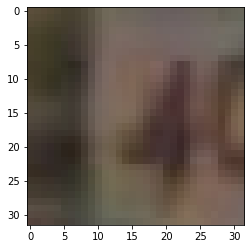

Ground Truth Label:  [4]
prediction:  4


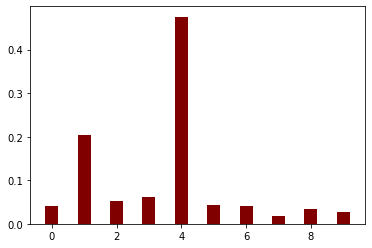

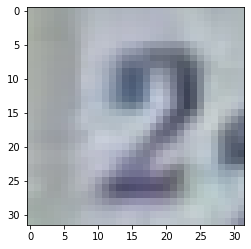

Ground Truth Label:  [2]
prediction:  2


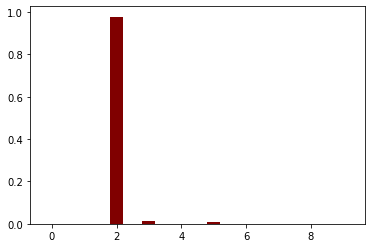

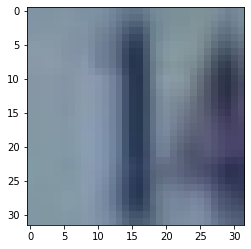

Ground Truth Label:  [1]
prediction:  1


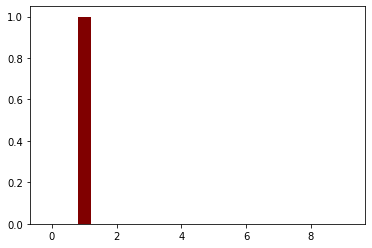

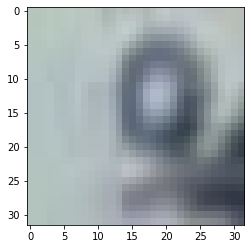

Ground Truth Label:  [9]
prediction:  4


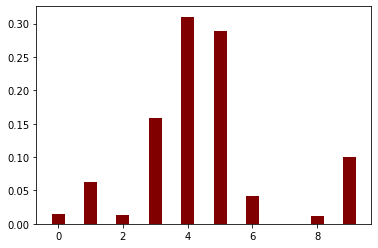

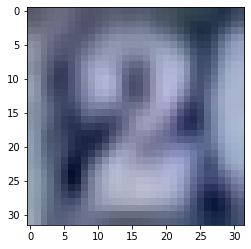

Ground Truth Label:  [2]
prediction:  2


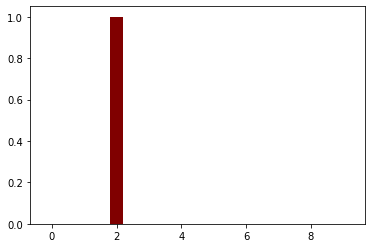

In [180]:
#X_test_unmodified is used for displaying the images
#X_test is used for getting predictions
for i in samples:
    plt.imshow(X_test_unmodified[:, :, :, i])
    plt.show() #display the image
    print("Ground Truth Label: ", y_test[i]) #display the ground truth
    get_prediction_MLP(X_test[i, :, :, :]) #display the predicted label

In [141]:
#get new CNN model
new_model_CNN = get_model_CNN()

#load best weights
new_model_CNN.load_weights('checkpoints_best_only_CNN/checkpoint')

In [143]:
#select 5 images from X_test1 at random
samples = np.random.randint(X_test1.shape[0], size=5)
print(samples)

[24790 11618 11966  1853    20]


In [181]:
#define function for displaying the prediction for a given image
def get_prediction_CNN(img):
    x = img[np.newaxis, ...]
    print("prediction: ", np.argmax(new_model_CNN.predict(x)))
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    predictions = new_model_CNN.predict(x)
    plt.bar(labels, predictions[0, :], color ='pink', width = 0.4) 
    plt.show()

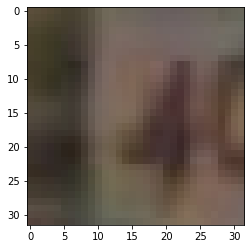

Ground Truth Label:  [4]
(32, 32, 1)
prediction:  4


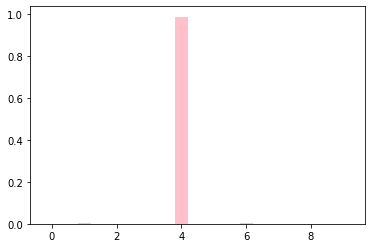

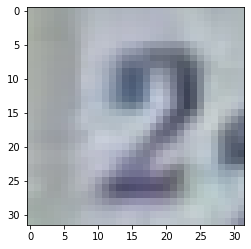

Ground Truth Label:  [2]
(32, 32, 1)
prediction:  2


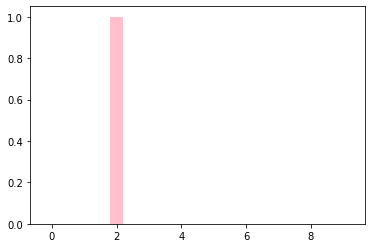

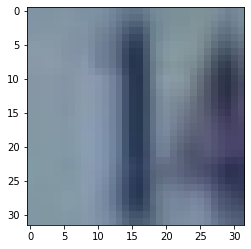

Ground Truth Label:  [1]
(32, 32, 1)
prediction:  1


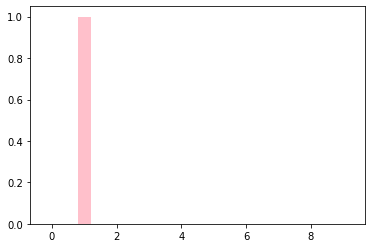

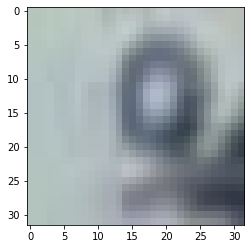

Ground Truth Label:  [9]
(32, 32, 1)
prediction:  9


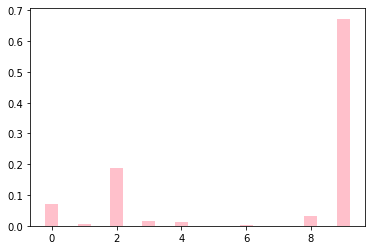

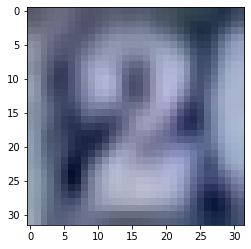

Ground Truth Label:  [2]
(32, 32, 1)
prediction:  2


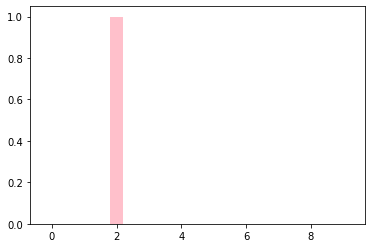

In [182]:
#X_test_unmodified is used for displaying the images
#X_test1 is used for getting predictions
for i in samples:
    plt.imshow(X_test_unmodified[:, :, :, i])
    plt.show() #display the image
    print("Ground Truth Label: ", y_test[i]) #display the ground truth
    print(X_test1[i, :, :, :].shape)
    get_prediction_CNN(X_test1[i, :, :, :]) #display the predicted label